In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import sklearn.datasets as datasets
import sklearn.model_selection as model_selection
import statsmodels.stats.api as sms

5. In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the Default data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

In [12]:
default_df = pd.read_csv('default.csv')
default_df = default_df.drop(default_df.columns[0], axis=1)
default_df['default'] = default_df['default'].map({'No' : 0, 'Yes' : 1})
default_df['student'] = default_df['student'].map({'No' : 0, 'Yes' : 1})
default_df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


(a) Fit a logistic regression model that uses income and balance to predict default.

In [16]:
smf.logit(formula='default ~ income + balance', data = default_df).fit().summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Mon, 24 Sep 2018   Pseudo R-squ.:                  0.4594
Time:                        19:11:48   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
balance        0.0056      0.000     24.835      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

(b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

i. Split the sample set into a training set and a validation set

ii. Fit a multiple logistic regression model using only the training observations

iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5

iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

In [47]:
train, test = model_selection.train_test_split(default_df, test_size=0.5, random_state=0)
logit_model = smf.logit(formula='default ~ income + balance', data= train).fit()
((logit_model.predict(test) > 0.5) == test['default']).mean()

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10


0.971

(c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

This is an ambiguous question, do they want different ratios of `train : test` or different random seeds?

**random seeds**

`random_state=0` : `0.971`

`random_state=1` : `0.975`

`random_state=2` : `0.9752`

The estimates have low variance.

**ratios**

`test_size=0.25` : `0.9744`

`test_size=0.5` : `0.9752`

`test_size=0.75` : `0.9744`

The estimates have low variance.


(d) Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

- Test error without including student: `0.971`
- Test error including student: `0.9708`
- There is not a significant change in the test error rate.

In [50]:
train, test = model_selection.train_test_split(default_df, test_size=0.5, random_state=0)
logit_model = smf.logit(formula='default ~ income + balance + student', data= train).fit()
print(((logit_model.predict(test) > 0.5) == test['default']).mean())

Optimization terminated successfully.
         Current function value: 0.072293
         Iterations 10
0.9708


6. We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the Default data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression co- efficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the glm() function. Do not forget to set a random seed before beginning your analysis.

In [53]:
train, test = model_selection.train_test_split(default_df, test_size=0.5, random_state=0)
logit_model = smf.logit(formula='default ~ income + balance', data= train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4997
Method:                           MLE   Df Model:                            2
Date:                Mon, 24 Sep 2018   Pseudo R-squ.:                  0.4500
Time:                        19:52:15   Log-Likelihood:                -364.78
converged:                       True   LL-Null:                       -663.25
                                        LLR p-value:                2.369e-130
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.3896      0.635    -17.935      0.000     -12.634     -10.145
income       1.58e-05   7.34e-06      2.151      0.031     1.4e-06    3.02e-05
balance        0.0056      0.000     16.792      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

(b) Write a function, boot.fn(), that takes as input the Default data set as well as an index of the observations, and that outputs the coefficient estimates for income and balance in the multiple logistic regression model.

In [56]:
def boot(data, func, r):
    i = 0
    stats = pd.DataFrame()
    while i < r:
        sample = data.sample(data.shape[0], replace=True)
        value = func(sample)
        stats[i] = value
        i+=1
    std = stats.std(axis=1)
    return pd.DataFrame(data={'original': func(data), 'std_err' : std})

def logit_coeff(data):
    logit_model = smf.logit(formula='default ~ income + balance', data= train).fit()
    return logit_model.params

(c) Use the boot() function together with your boot.fn() function to estimate the standard errors of the logistic regression coefficients for income and balance.

In [57]:
boot(default_df, logit_coeff, 1000)

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

,original,std_err
Intercept,-11.389575,0.000000e+00
income,0.000016,0.000000e+00
balance,0.005565,8.677957e-19


(d) Comment on the estimated standard errors obtained using the glm() function and using your bootstrap function.

- They are almost identical

7. In Sections `5.3.2` and `5.3.3`, we saw that the `cv.glm()` function can be used in order to compute the LOOCV test error estimate. Alternatively, one could compute those quantities using just the `glm()` and `predict.glm()` functions, and a for loop. You will now take this approach in order to compute the LOOCV error for a simple logistic regression model on the `Weekly` data set. Recall that in the context of classification problems, the LOOCV error is given in `(5.4)`.

In [69]:
weekly_df = pd.read_csv('weekly.csv')
weekly_df = weekly_df.drop(weekly_df.columns[0], axis=1)
weekly_df['Direction'] = weekly_df['Direction'].map({'Up' : 1, 'Down' : 0})
weekly_df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,1


(a) Fit a logistic regression model that predicts Direction using Lag1 and Lag2.

In [83]:
logit_model = smf.logit(formula='Direction ~ Year + Lag1 + Lag2', data=weekly_df[1:]).fit()

Optimization terminated successfully.
         Current function value: 0.682882
         Iterations 4


(c) Use the model from (b) to predict the direction of the first observation. You can do this by predicting that the first observation will go up if P(Direction="Up"|Lag1, Lag2) > 0.5. Was this observation correctly classified?

- No

In [85]:
(logit_model.predict(weekly_df.iloc[0]) > 0.5) == weekly_df['Direction'].iloc[0]

0    False
dtype: bool

(d) Write a for loop from `i=1` to `i=n`, where `n` is the number of observations in the data set, that performs each of the following steps:

i. Fit a logistic regression model using all but the `ith` observation to predict `Direction` using `Lag1` and `Lag2`.

ii. Compute the posterior probability of the market moving up for the `ith` observation.

iii. Use the posterior probability for the `ith` observation in order to predict whether or not the market moves up.

iv. Determine whether or not an error was made in predicting the direction for the `ith` observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.

In [87]:
errs = []
weekly_df
for train_idx, test_idx in model_selection.KFold(n_splits=weekly_df.shape[0]).split(weekly_df):
    train_dat = weekly_df.iloc[train_idx]
    test_dat = weekly_df.iloc[test_idx]
    logit_model = smf.logit(formula='Direction ~ Lag1 + Lag2', data=train_dat).fit()
    errs.append(((logit_model.predict(test_dat) > 0.5) == test_dat['Direction']).mean())

Optimization terminated successfully.
         Current function value: 0.683147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683203
  

Optimization terminated successfully.
         Current function value: 0.683134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683352
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683344
  

Optimization terminated successfully.
         Current function value: 0.683208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683381
  

Optimization terminated successfully.
         Current function value: 0.683176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683193
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683415
  

Optimization terminated successfully.
         Current function value: 0.683233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683479
  

Optimization terminated successfully.
         Current function value: 0.683288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683409
  

Optimization terminated successfully.
         Current function value: 0.683292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683560
  

Optimization terminated successfully.
         Current function value: 0.683242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683378
  

Optimization terminated successfully.
         Current function value: 0.683403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683100
  

Optimization terminated successfully.
         Current function value: 0.683199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683292
  

Optimization terminated successfully.
         Current function value: 0.683291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683386
  

Optimization terminated successfully.
         Current function value: 0.683259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683352
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683121
  

Optimization terminated successfully.
         Current function value: 0.683289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683320
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683352
  

Optimization terminated successfully.
         Current function value: 0.683397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683374
  

(e) Take the average of the `n` numbers obtained in (d)iv in order to obtain the LOOCV estimate for the test error. Comment on the results.

- Prediction accuracy is 55%

In [89]:
pd.DataFrame(errs).mean()[0]

0.5500459136822773

8. We will now perform cross-validation on a simulated data set.

(a) Generate a simulated data set as follows:

```
set.seed(1)
x=rnorm(100)
y=x-2*x^2+rnorm(100)
```

In this data set, what is `n` and what is `p`? Write out the model used to generate the data in equation form.

- `n = 100`
- `p = 1`
- `x = N ~ (0, 1)`
- `y = -2x^2 + epsilon`

In [119]:
n = 100
x = np.random.normal(size=n)
y = x - 2 * x ** 2 + np.random.normal(size=n)

(b) Create a scatterplot of `X` against `Y` . Comment on what you find.

- As we might expect from the formula in (a), the data follows the form of an inverted parabola with some noise.

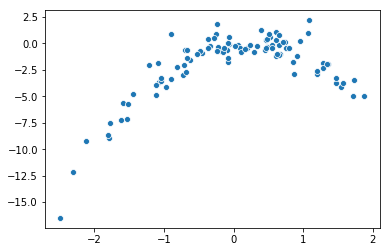

In [120]:
sns.scatterplot(x, y)

(c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:

i. `Y = β0 + β1X + ε`

ii. `Y = β0 + β1X + β2X2 + ε`

iii. `Y = β0 +β1X +β2X2 +β3X3 +ε`

iv. `Y = β0 +β1X +β2X2 +β3X3 +β4X4 +ε`

In [130]:
def k_cv_err(k, df, seed, formula):
    errs = []
    for train_idx, test_idx in model_selection.KFold(n_splits=k, random_state=seed).split(df):
        train_dat = df.iloc[train_idx]
        test_dat = df.iloc[test_idx]
        lin_reg = smf.ols(formula=formula, data=train_dat).fit()
        errs.append(((test_dat['y'] - lin_reg.predict(test_dat)) ** 2).mean())
    return pd.DataFrame(errs).mean()[0]

seed = 0
formulae = ['y ~ x', \
            'y ~ x + np.power(x, 2)', \
            'y ~ x + np.power(x, 2) + np.power(x, 3)',
            'y ~ x + np.power(x, 2) + np.power(x, 3) + np.power(x, 4)']
df = pd.DataFrame({'x' : x, 'y' : y})
[k_cv_err(df.shape[0], df, seed, f) for f in formulae]

[6.794905844691184, 1.0245281466670826, 1.0620845270746653, 1.089129915670262]

(d) Repeat (c) using another random seed, and report your results.
Are your results the same as what you got in (c)? Why?

- The test error estimates are identical.
- This is to be expected as LOOCV is deterministic.

(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

- `'y ~ x + np.power(x, 2)'` had the lowest test error 
- This is to be expected as the data were generated from a quadratic model.

(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?

- Yes: the coefficients for polynomial terms greater than 2 are not statistically significant.

In [133]:
for f in formulae:
    print(smf.ols(formula=f, data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     38.46
Date:                Mon, 24 Sep 2018   Prob (F-statistic):           1.33e-08
Time:                        21:07:40   Log-Likelihood:                -233.66
No. Observations:                 100   AIC:                             471.3
Df Residuals:                      98   BIC:                             476.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9088      0.253     -7.547      0.0

9. We will now consider the Boston housing data set, from the MASS library.

In [165]:
boston = datasets.load_boston()
boston = pd.DataFrame(data=np.c_[boston['data'], boston['target']], columns= [c for c in boston['feature_names']] + ['MEDV'])
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [168]:
boston['MEDV'].describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

In [145]:
boston['MEDV'].mean()

22.532806324110677

(a) Based on this data set, provide an estimate for the population mean of `medv`. Call this estimate `μ_hat`.

*Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.*

In [147]:
boston['MEDV'].std() / boston.shape[0] ** 0.5

0.40886114749753505

(c) Now estimate the standard error of μ_hat using the bootstrap. How does this compare to your answer from (b)?

- It is lower

In [179]:
rho = 10 ^ 4
i = 0
means = []
while i < rho:
    sample = boston.sample(n=boston.shape[0], replace=True)
    means.append(sample['MEDV'].mean())
    i += 1
std_err = np.array(means).std()
#mean_of_means = np.array(means).mean()
print(std_err)

0.2616310836264143


(d) Based on your bootstrap estimate from (c), provide a `95%` confidence interval for the mean of `medv`. Compare it to the results obtained using `t.test(Boston$medv)`.

*Hint: You can approximate a `95%` confidence interval using the formula:*

```
[μ_hat − 2SE(μ_hat), μ_hat + 2SE(μ_hat)]
```

- The CIs calculated from the bootstrap SE estimate are narrower

In [191]:
(boston['MEDV'].mean() - (2 * std_err), boston['MEDV'].mean() + 2 * std_err)

(22.00954415685785, 23.056068491363504)

In [193]:
sms.DescrStatsW(boston['MEDV']).tconfint_mean()

(21.72952801457859, 23.336084633642756)

(e) Based on this dataset, provide an estimate, `μ_med_hat`, for the median value of `medv` in the population.

In [176]:
boston['MEDV'].median()

21.2

(f) We now would like to estimate the standard error of `μ_med_hat`. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap.

- The estimate for the median has higher SE than the estimate for the mean

In [177]:
rho = 10 ^ 4
i = 0
meds = []
while i < rho:
    sample = boston.sample(n=boston.shape[0], replace=True)
    meds.append(sample['MEDV'].median())
    i += 1
std_err = np.array(meds).std()
print(std_err)

0.3624604130390076


(g) Based on this data set, provide an estimate for the tenth percentile of `medv` in Boston suburbs. Call this quantity `μ_hat_0.1` (You can use the `quantile()` function.)

In [198]:
boston['MEDV'].quantile(0.1)

12.75

(h) Use the bootstrap to estimate the standard error of `μ_hat_0.1`. Comment on your findings.

- SE of tenth quantile estimate is 0.5397112795802241
- ?other comments

In [200]:
rho = 10 ^ 4
i = 0
quants = []
while i < rho:
    sample = boston.sample(n=boston.shape[0], replace=True)
    quants.append(sample['MEDV'].quantile(0.1))
    i += 1
std_err = np.array(quants).std()
print(std_err)

0.5397112795802241
